# Podcast Reviews Analysis

In this notebook I will analyze Apple iTunes podcasts reviews. The goal of the analysis if threefold:

1. I will make a short general review of the database by analyzing its structure and data. The goal of this part is to get a general sense of what story the data is trying to tell us.
2. In the second part of the analysis, I will perform a number of statistical analysis. The goal is to:

    a) Idenftify the patterns in the podcast reviews.
    
    b) Define at least two possbile samples for comparison analysis.
    
    c) Perform statistical analysis of the chosen samples.
    
    d) Visualize the findings with SNS and Google Data studio.
    
3. The third goal of this analysis is to practice SQL, Statics, Google Data Studio and Python progaming techniques.

By the end of this analysis I hope to distinguish at least two sample groups, draw some conclusions on what distinguishes these groups, and identify, whether these distinctions are statistically significant.

First, I import all the needed libraries and make needed notebook setting.

In [173]:
import sqlite3
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import re
from scipy.stats import kruskal
import scipy.stats as stats
import statsmodels.api as sm
from scipy.stats import ttest_ind, mannwhitneyu
from heapq import nsmallest


%matplotlib inline
%config InlineBackend.figure_format = 'svg'

Next, I establish connection to the database and read the tables to review the structure.

In [107]:
conn = sqlite3.connect('podcast.sqlite')
tables=[]
def sql_fetch(conn):
    cur = conn.cursor()
    cur.execute('SELECT name FROM sqlite_master where type = "table"')
    table_name = list(cur.fetchall())
    tables.append(table_name)
sql_fetch(conn)
tables = [item[0] for sublist in tables for item in sublist]
tables

['runs', 'podcasts', 'categories', 'reviews']

#### 1. Initial Analysis

There are four tables - 'runs', 'podcasts', 'categories', and 'reviews'. After reviewing the content of them, I decided that I will only need 'podcasts', 'categories', and 'reviews' tables. Also, some of the table will need to be joined.

With the following code, I read all tables into dataframes, so that I would access them any time individually for a review or analysis.

In [108]:
table_dict={}
for table in tables:
    table_dict[table] = pd.read_sql(f'SELECT * from {table}', conn)
for key in table_dict:
    globals()[key] = table_dict[key].copy()

After the review, I decided that I want to create a new table that would be the combination of two other tables. The goal was to add categories to the reviews.

In [109]:
category_statement = '''SELECT r.podcast_id, r.content, r.rating, DATE(r.created_at) as date, c.category
                      FROM reviews r
                      JOIN (SELECT podcast_id, MIN(category) AS category
                            FROM categories
                            GROUP BY podcast_id
                            ) c
                      ON r.podcast_id = c.podcast_id
'''
reviews_category = pd.read_sql(category_statement, conn)
reviews_category.head()

,podcast_id,content,rating,date,category
0,c61aa81c9b929a66f0c1db6cbe5d8548,Thanks for providing these insights. Really e...,5,2018-04-24,arts
1,c61aa81c9b929a66f0c1db6cbe5d8548,Super excited to see this podcast grow. So man...,5,2018-05-10,arts
2,ad4f2bf69c72b8db75978423c25f379e,"I'm a liberal myself, but its pretty obvious a...",1,2019-06-11,arts
3,ad4f2bf69c72b8db75978423c25f379e,I find Tedx talks very inspirational but I oft...,5,2018-05-31,arts
4,ad4f2bf69c72b8db75978423c25f379e,"I love this podcast, it is so good.",5,2019-06-19,arts


Next, I will create a dataset for visual analysis in Google Data Studio. The first visual that I wanted to place there is a line chart of how podcast reviews are distributes in terms of years and see if there is a significant pattern there.

In [170]:
reviews_category['date'] = pd.to_datetime(reviews_category['date'])
reviews_category['year'] = reviews_category['date'].dt.year.fillna(0).astype(int)
reviews_category = reviews_category[reviews_category['year']!=0]
years_grouped = reviews_category.groupby('year').size().to_frame('count').reset_index()
years_grouped.to_csv('reviews_by_year.csv', index=False, encoding='utf-8')


In the Google Data Studio you can follow the link to see the distribution of review by year.
https://lookerstudio.google.com/u/0/reporting/5b38c38a-4ed1-4d18-80a5-da295d7d971e/page/p_qkju0zzz5c

As you see in the provided visual, the Covid period 2019 - 2021 dominated in podcast listening and reviewing.

#### 2. Statistical Analysis

There are 110 different categories in the podcast list. First, I want to see if there is a statistical difference in their rating means. The ratings are from 1 to 5. Most means, vary between 4 and 5. Before carrying any statisical test, we should define whether the distribution is normal. For that I will do three steps:

1. View the rating distribution visually?
2. Perform Kruskal-Wallis, which is usually done for distributions that are not considered normal.
3. Perform one way ANOVA test, asuming that the distribution is normal due to the large sample size.

My H_null is that there is no significant difference between the means of the ratings between the categories.
H_alt is that there is a difference between the means.
I set significance level to be 0,05.

I will start from preparing a data for rating visual.

In [110]:
rating_distribution = reviews_category.groupby('rating').rating.count()
rating_distribution = rating_distribution.to_frame('count').reset_index()
rating_distribution

,rating,count
0,1,115206
1,2,45229
2,3,51482
3,4,61918
4,5,1769462


I will create standard suggested visuals for identifying of the normal distribution - histogram and qq plot.

Text(0.5, 1.0, 'QQ Plot')

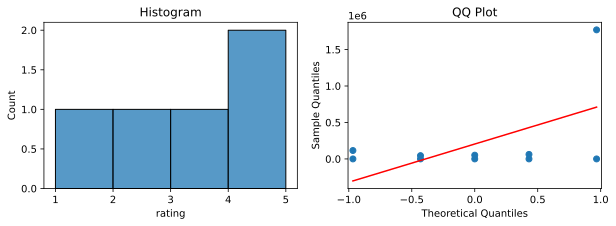

In [111]:
fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(10,3))
sns.histplot(rating_distribution,  x='rating', ax=ax1)
ax1.set_title('Histogram')
sm.qqplot(rating_distribution, line='s', ax=ax2)
ax2.set_title('QQ Plot')

Looking at both plots, we can hardly see any normal distribution. Even looking at the numeric values, we see that 5* rating exeeds the closest rating by 20 times. So, this suggests using Kruskal-Wallis test.

In [176]:
grouped_categories = reviews_category.groupby('category')['rating'].apply(list)
grouped_categories = pd.DataFrame(grouped_categories).reset_index()
stat, p_value = kruskal(*grouped_categories.T)
print(f'''Test value is {stat} and p is equal to {p_value:.2f}.''')

Test value is 109.0 and p is equal to 0.48.


The p value that equals to 0,48 is way higher than my significance level 0,05, which would suggest that I have to accept H_null and claim that there is no difference between the different categories rating means. However, even looking at plain numbers, we can see that the difference is significant. I will choose the 10 categories with the highest mean difference.

In [189]:
grouped_categories = reviews_category.groupby('category').mean()
diffs = {}
for i, cat1 in enumerate(grouped_categories.index):
    for j, cat2 in enumerate(grouped_categories.index):
        if j <= i:
            continue
        diff = abs(grouped_categories.loc[cat1, 'rating'] - grouped_categories.loc[cat2, 'rating'])
        diffs[(cat1, cat2)] = diff
top_pairs = sorted(diffs.items(), key=lambda x: x[1], reverse=True)[:10]
for pair, diff in top_pairs:
    print(f"{pair[0]} vs {pair[1]}: {diff:.2f}")

science-mathematics vs true-crime: 0.78
sports-rugby vs true-crime: 0.78
news vs science-mathematics: 0.77
news vs sports-rugby: 0.77
business-non-profit vs true-crime: 0.74
education-self-improvement vs true-crime: 0.74
science-social-sciences vs true-crime: 0.74
kids-family-pets-animals vs true-crime: 0.74
science-earth-sciences vs true-crime: 0.73
business-non-profit vs news: 0.73


C:\Users\DeivydasPagojus\AppData\Local\Temp\ipykernel_16572\1199490430.py:1: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  grouped_categories = reviews_category.groupby('category').mean()


The result suggest that at leats 10 pairs, which is ~ 20% of all categories, have a difference, which is almost by 1 grade. Thus, intuitively I think that Kruskal-Wallis may not work for this distribution, perhaps becuase the sample is quite large - more than 2 million reviews. 

Statistical theory suggests that if sample is large enough and is random, we can consider the distribution as normal. For the categorical data from 1 to 5, one way ANOVA test shold be an alternative approach to evaluate the hypothesis.

In [183]:
grouped_categories = reviews_category.groupby('category')['rating'].apply(list)
f_value, p_value = stats.f_oneway(*[grouped_categories[i] for i in grouped_categories.index])
print(f"Statistics test is equal to {f_value:.1f}, while p value is {p_value:.2f}.")


Statistics test is equal to 665.7, while p value is 0.00.


In this test, we get a p_value equal to 0. Although, this is unusual rezult, it is likely that it is caused by the large sample size. For the sake of surety, I will additioinally perform standart t-test. However, initial t-test returned precision error, thus Google suggested using Mann_Whitney U test, which is applicable to different kinds of distributions.

With this test, I will try to see if there are groups of categories that have a significant differences and create a dataset of those.

In [115]:
groups = {}
p_values = {}
p_alt = 0
p_null = 0
for category, data in reviews_category.groupby('category')['rating']:
    groups[category] = data.tolist()
for i, category1 in enumerate(groups.keys()):
    for j, category2 in enumerate(groups.keys()):
        if i < j:
            group1 = groups[category1]
            group2 = groups[category2]
            t, p = mannwhitneyu(group1, group2)
            if p < 0.05:
                p_alt+=1
                p_values[(category1, category2)] = p
            else:
                p_null+=1

In [116]:
print(f'''There are {p_alt} of category pairs that have significantly different rating mean,
      and {p_null} that have insignificant mean difference. Pairs with significant difference are
      by {(p_alt-p_null)/p_alt*100:.0f}% more.''')

There are 3929 of category pairs that have significantly different rating mean,
      and 2066 that have insignificant mean difference. Pairs with significant difference are
      by 47% more.


The test showed that 3929 pairs of categories have significant difference in their ratings, while 2066 pairs do not. I am interested in those categories pair that have significant difference in their ratings. I want to create two different group of categories that have the highest difference, hense the smallest p-value, and walk through their textual reviews to see what are the key words of positive and negative assertions of these podcasts.

In [182]:
category_set1 = set()
category_list1 = []
category_set2 = set()
category_list2 = []
max_pairs = len(p_values) 
for pair in nsmallest(max_pairs, p_values.items(), key=lambda x: x[1]):
    category1, category2 = pair[0]
    if len(category_set1) >= max_pairs:
        break
    if category1 not in category_set1 and category1 not in category_set2:
        category_list1.append(category1)
        category_set1.add(category1)
        if len(category_set1) >= max_pairs:
            break
    if category2 not in category_set1 and category2 not in category_set2:
        category_list2.append(category2)
        category_set2.add(category2)
        if len(category_set1) >= max_pairs:
            break
print(f'''The first group contains {(len(category_list2))} and the second - {(len(category_list1))}.''')

The first group contains 46 and the second - 63.


The frist category group is made of 46 categories, and the second is 63 categotries. Now, I will create two different dataframes that will be separated by these ctegorical grouping.

In [118]:
group_1 = pd.DataFrame()
group_2 = pd.DataFrame()

for category in category_list1:
    df = reviews_category[reviews_category['category'] == category]
    group_1 = pd.concat([group_1, df])

for category in category_list2:
    df = reviews_category[reviews_category['category'] == category]
    group_2 = pd.concat([group_2, df])

Now, I have created two dataframes with the podcasts review that have different categories and their rating means differ significantly. Before goinging into analysis of key words and phrases, I will perform additional statistical calculations. This is done in order to make sure that these two sample datasets are significanlty different in terms of their rating.

My research question is the following:

Out of two population samples, which are made of different prodcasts categories, is the difference in rating mean significant enough, to evaluate their written reviews individually, while looking for word and phrase patterns.

1. I will perform the t-test.
2. H0 suggests that df1 and df2 ratings do not differ significantly. Ha suggests that the difference is significant.
3. I will establish confidence interval.
4. I set significance level to 0,05.

In [120]:
group1_ratings = group_1['rating'].tolist()
group2_ratings = group_2['rating'].tolist()
result = ttest_ind(group1_ratings, group2_ratings, equal_var=False)
mean_diff = np.mean(group1_ratings) - np.mean(group2_ratings)
std_err = np.sqrt(np.var(group1_ratings, ddof=1)/len(group1_ratings) + np.var(group2_ratings, 
                                                                        ddof=1)/len(group2_ratings))
t = result.statistic
p = result.pvalue
lower_bound = mean_diff - 1.96 * std_err
upper_bound = mean_diff + 1.96 * std_err
print(f'''The t value is {t}, and p_value being {p}. Both measures suggest us that we can 
reject the null hypothesis and accept the alternative on.
The confidence interval is{lower_bound, upper_bound}. Again, there is no 0 in the confidence in interval,
which additionally leads us to rejecting the H0 hypothesis.''')

The t value is 112.34132588724547, and p_value being 0.0. Both measures suggest us that we can 
reject the null hypothesis and accept the alternative on.
The confidence interval is(0.18231124892419223, 0.18878571451009088). Again, there is no 0 in the confidence in interval,
which additionally leads us to rejecting the H0 hypothesis.


The p value being 0 and confidence level not including 0, suggest that we can reject the null-hypothesis. Thus, I conclude that with the 95% if confidence, the two groups fo podcast reviews have significantly difference rating mean and can be analysed as separate populations.

Now, I will perform exploratory analysis on these different populations. I will analyze the following parameters:

1. Which podcats category group is better rated?
2. Which 10 categories within each group with the highest number of review and the best ratings?
3. What key words and phrases dominate in each group?

##### Rating means

In [121]:
group1_mean = group_1['rating'].mean()
group2_mean = group_2['rating'].mean()
print(f'''The first group has a rating mean equal to {group1_mean:.2f}, 
while the other - {group2_mean:.2f}.''')

The first group has a rating mean equal to 4.78, 
while the other - 4.60.


Although, the means of the groups does not seem to differ that much, statistical tests suggested that the difference is significant. Thus, it seems that the first group has better overall rating than the second.

Now, I will list top 10 categories within each group with the best ratings. The first criteria is the number of reviews, though, because this give more objectivity, thant only few good or bad ratings.

In [122]:
group1_grouped = group_1.groupby('category').agg(rating_mean=('rating','mean'),rating_number=('podcast_id',
                                          'count')).reset_index()
group1_grouped = group1_grouped.sort_values(by=['rating_number','rating_mean'], ascending=[False, False])
group1_grouped.head(10)

,category,rating_mean,rating_number
0,arts,4.727782,136508
14,christianity,4.819207,82774
9,business-entrepreneurship,4.940938,6163
49,society-culture-personal-journals,4.870495,4162
12,business-marketing,4.933860,4052
8,business-careers,4.922101,3864
61,sports-wilderness,4.749475,3808
39,leisure-video-games,4.690380,3711
24,health-fitness-fitness,4.822461,3357
23,health-fitness-alternative-health,4.832368,3281


In [123]:
group2_grouped = group_2.groupby('category').agg(rating_mean=('rating','mean'),rating_number=('podcast_id',
                                          'count')).reset_index()
group2_grouped = group2_grouped.sort_values(by=['rating_number','rating_mean'], ascending=[False, False])
group2_grouped.head(10)

,category,rating_mean,rating_number
1,comedy,4.619244,325179
0,business,4.837827,200829
29,society-culture,4.420780,200354
2,education,4.807802,146292
16,news,4.230611,138870
32,sports,4.592635,128364
7,health-fitness,4.813504,110335
40,tv-film,4.559520,77218
39,true-crime,4.219629,73278
12,leisure,4.741662,67791


Now, I will prapare the data for Google Data Studio visual analysis

In [ ]:
g1_top = group1_grouped.head(10)
g2_top = group2_grouped.head(10)
g1_top.to_csv('g1_top.csv', index=False)
g2_top.to_csv('g2_top.csv', index=False)

In the link bellow, you will find a visual in Google Data studio displaying the top 10 categories for each group. 
https://lookerstudio.google.com/u/0/reporting/5b38c38a-4ed1-4d18-80a5-da295d7d971e/page/p_p6z2kqzz5c

Interesting observation, that in the first group two categories dominate: Art and Christianity. While the other group is much more normally distributed.

Next, I selected a number of words and phrases that could be found in the textual part of the review. I was carefully choosing the words that could have a direct meaning with little oposite interpretation chance. Some phrases do have a possible dublication, e.g. 'very good' and 'not very good', could appear in the same comment. However, initial review of the results suggested that 'very good' phrase outnumbers the opposite by almost ten times, and thus does not have a significant impact on the analysis that I want to make. 

I will add additional column to each group table with the adjective word or phrase, if found, and create a smaller table with they found key words. After I create this table, I will create a word cloud to illustrate the dominant words and phrases.

In [124]:
for df in [group_1, group_2]:
    vocabulary = ['shallow', 'boring', 'nonesense', 'useless', 'lovely', 'exciting', 'deep',
                  'wonderful','amazing','cheap', 'sad', 'nice', 'cheesy','would recommend','very bad',
                  'very good','very useful','very interesting','not interesting','not bad','no good',
                  'not good','not useful','nothing new','nothing valuable','not boring','was useful',
                  'would not recommend','not very good','waste of time','I would recommend',
                  'not too bad','I loved it','this was useless','not very useful',
                  'not very interesting','nothing was good','no new information','was not useful',
                  'was very good', 'recommend watching this','I love it', 'thanks', 'amazing!', 
                  'hate this', 'loved this', 'awesome', 'entertaining', 'informative', 
                  'not informative', 'insightful', 'not insightful','dissapointing',
                  'engaging', 'fascinating', 'hilarious', 'inspiring', 'irritating', 'motivating', 
                  'provocative','relevant', 'not relevant', 'not very relevant', 'thought-provoking',
                  'unique', 'not-unique', 'captivating', 'dull', 'gripping', 'incoherant', 'intriguing', 
                  'memorable', 'mind-blowing', 'mundane', 'original', 'overrated', 'refreshing', 
                  'stimulating', 'superficial', 'tedious', 'thrilling', 'uninspiring', 'unoriginal', 
                  'valuable', 'worthless', 'ambiguous', 'confusing', 'convoluted', 'engaging', 
                  'exhausting', 'exhilarating', 'flawed', 'frustrating', 'inspirational', 'instructive', 
                  'intricate', 'misleading', 'overhyped', 'persuasive', 'pointless', 'powerfull', 
                  'promising', 'provocative', 'satisfying', 'simplistic', 'sophisticated', 'surprising', 
                  'timeless', 'unconvincing', 'unfocused', 'unremarkable', 'vague', 'well-researched']
    df['content'] = df['content'].str.lower()
    pattern = re.compile('|'.join(vocabulary))
    search_pattern = lambda row:pattern.search(row['content']).group(0) \
                 if pattern.search(row['content']) else ''
    df['select'] = df.apply(search_pattern, axis=1)

I will clean the result so that only those reviews that have the selected key words are further analysed. Also, I will group key words by count to see which adverbs dominate.

In [125]:
group_1_clean = group_1[group_1['select']!='']
g1_grouped = group_1_clean.groupby('select').size().reset_index(name='count')
g1_grouped = g1_grouped.sort_values('count', ascending=False).reset_index(drop=True)
g1_grouped = g1_grouped.rename_axis('index')
g1_grouped.head()

,select,count
index,,
0,amazing,14824
1,thanks,12129
2,awesome,8656
3,wonderful,7204
4,informative,7058


In [126]:
group_2_clean = group_2[group_2['select']!='']
g2_grouped = group_2_clean.groupby('select').size().reset_index(name='count')
g2_grouped = g2_grouped.sort_values(by='count', ascending=False).reset_index(drop=True)
g2_grouped = g2_grouped.rename_axis('index')

I will create dataset for Google Data Studie word cloud.

In [150]:
g1_grouped.to_csv('g1_words.csv', index=False)
g2_grouped.to_csv('g2_words.csv', index=False)

In the link bellow you will find the word clouds for both groups dominating adverbs in their reviews. 
https://lookerstudio.google.com/u/0/reporting/5b38c38a-4ed1-4d18-80a5-da295d7d971e/page/vZOPD
At the first sigh, the collectioin of key words does not differ much.

I will merge two tables for additional comparison purpose. They are sorted by the ascending order on total reviews, thus I will join them on the index column.

In [127]:
joined_groups = pd.merge(g1_grouped, g2_grouped, on='index', how='inner')
joined_groups.head(30)

,select_x,count_x,select_y,count_y
index,,,,
0,amazing,14824,amazing,77715
1,thanks,12129,thanks,62452
2,awesome,8656,awesome,47694
3,wonderful,7204,entertaining,41958
4,informative,7058,informative,40262
5,deep,6769,hilarious,34445
6,entertaining,6656,wonderful,24546
7,hilarious,4608,deep,24156
8,insightful,4448,nice,21561


Initial review of these merged tables is confusing. A lot of adjective words are the same and in the same possition. In fact, the second group, with the lower average mean has more top positive word count than the first group with the higher rating mean. This is mainly due to the fact that the second group has more categories within.

I will perform additional calculations, to make sure that the two groups actually are different. I will add numeric sentiment column to each, and calculate the sum number of all possitive and negative sentiments. In additional , i will perform corelation analysis of rating and sentiment numeric values.

For that purpose, I will create a function. Function is needed here because I will apply it to four different tables.

In [ ]:
def get_sentiment(word):
    if word in ['lovely', 'exciting', 'deep', 'wonderful', 'amazing', 'recommend watching this', 
                'I love it', 'thanks', 'amazing!', 'loved this', 'awesome', 'entertaining', 'informative',
                'insightful', 'dissapointing', 'engaging', 'fascinating', 'hilarious', 'inspiring', 
                'motivating', 'provocative', 'relevant', 'thought-provoking', 'unique', 'captivating', 
                'gripping', 'intriguing', 'memorable', 'mind-blowing', 'original', 'refreshing', 
                'stimulating', 'sophisticated', 'surprising', 'timeless', 'inspirational', 'instructive', 
                'intricate', 'persuasive', 'powerfull', 'promising', 'satisfying']:
        return 1
    elif word in ['shallow', 'boring', 'nonesense', 'useless', 'cheap', 'sad', 'cheesy', 'very bad', 
                  'not interesting', 'not bad', 'no good', 'not good', 'not useful', 'nothing new', 
                  'nothing valuable', 'not boring', 'would not recommend', 'not very good', 
                  'waste of time', 'not too bad', 'this was useless', 'not very useful', 
                  'not very interesting', 'nothing was good', 'no new information', 'was not useful', 
                  'uninspiring', 'unoriginal', 'worthless', 'ambiguous', 'confusing', 'convoluted', 
                  'exhausting', 'flawed', 'frustrating', 'misleading', 'overhyped', 'pointless', 
                  'simplistic', 'unconvincing', 'unfocused', 'unremarkable', 'vague']:
        return -1
    else:
        return 0

In [192]:
# apllying function
group_1_clean['sentiment'] = group_1['select'].apply(get_sentiment)
group_2_clean['sentiment'] = group_2['select'].apply(get_sentiment)
g1_grouped['sentiment'] = g1_grouped['select'].apply(get_sentiment)
g2_grouped['sentiment'] = g2_grouped['select'].apply(get_sentiment)

C:\Users\DeivydasPagojus\AppData\Local\Temp\ipykernel_16572\1365306121.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  group_1_clean['sentiment'] = group_1['select'].apply(get_sentiment)
C:\Users\DeivydasPagojus\AppData\Local\Temp\ipykernel_16572\1365306121.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  group_2_clean['sentiment'] = group_2['select'].apply(get_sentiment)


Now, I make an assumption that the total sum of positive and negative sentiments of the first group should be higher than of the second group.

In [129]:
sentiment_diff = g1_grouped['sentiment'].sum() - g2_grouped['sentiment'].sum()
print(f'''The difference between the sums of two groups sentiments is equal to {sentiment_diff}.
Although the difference is small, it corresponds to previous findings that group1 has better overal
rating''')

The difference between the sums of two groups sentiments is equal to 2.
Although the difference is small, it corresponds to previous findings that group1 has better overal
rating


Finally, I will perform correlation analysis for sentiment and rating value. For better correlation, I have transformed ratings into 3 groups, ratings 1 and 2 have correspong to -1, rating 3 to 0, and rating 4 and 5, to 1.

In [148]:
group_1_clean.loc[:,'rating_value'] = group_1_clean['rating'].apply(lambda x: -1 if x in [1, 2] else 1 
                                                                    if x in [4, 5] else 0)
group_2_clean.loc[:,'rating_value'] = group_2_clean['rating'].apply(lambda x: -1 if x in [1, 2] else 1 
                                                                    if x in [4, 5] else 0)

C:\Users\DeivydasPagojus\AppData\Local\Temp\ipykernel_16572\3210373539.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  group_1_clean.loc[:,'rating_value'] = group_1_clean['rating'].apply(lambda x: -1 if x in [1, 2] else 1
C:\Users\DeivydasPagojus\AppData\Local\Temp\ipykernel_16572\3210373539.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  group_2_clean.loc[:,'rating_value'] = group_2_clean['rating'].apply(lambda x: -1 if x in [1, 2] else 1


In [193]:
group1_corr = group_1_clean['rating_value'].corr(group_1_clean['sentiment'])
group2_corr = group_2_clean['rating_value'].corr(group_2_clean['sentiment'])
print(f'''Correlation of group1 rating_value and sentiment analysis is equal to {group1_corr:.2f}, which is
positively moderate. The same is with group2 - {group2_corr:.2f}. This suggests, although not 
very strongly, that the sentiment analysis, that was performed on textual reviews, coresponds to 
the overall rating of the podcast.''')

Correlation of group1 rating_value and sentiment analysis is equal to 0.31, which is
positively moderate. The same is with group2 - 0.37. This suggests, although not 
very strongly, that the sentiment analysis, that was performed on textual reviews, coresponds to 
the overall rating of the podcast.


In [ ]:
conn.close()

# Conclusion

Some of the findings that the analysis showed:

1. Covid period was most active for podcast listening and reviewing. This is expected because people had more time.
2. General statistical analysis helped identify two potential groups of categories that had significant difference between each other. Statistics showed that the difference is significant, although looking with at the results the difference was less noticable - both mean difference and review adverbs did not differ too much.
3. When it is unclear how to treat the distribution, several different tests should be performed, both for normal and not normal distributions. These test can help to make sure that the rejection or acceptance of hypothesis is not subjective.
4. The most interesting finding was that the group with better rating had two dominant categories - arts and Christianity. While the other group was more normally distributed. It is likely that during the tough time, such as covid, people tend to look for comfort in art and faith and draw hope and meaning from the podcasts of these topics. 
5. Key adverb correlation with the overall rating of the podcast was moderate, however strong enough to consider it supporting main assumptions.


The analysis could be improved with the better word/phrase choise and using more of the sentiment analysis techniques. 
